In [1]:
import pandas as pd
import os.path as osp
import os
import statistics
from collections import Counter
from urllib import request
import json
from matplotlib import pyplot as plt
from matplotlib_venn import venn2_unweighted
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import re

get a table where the column names are the different KG settings

and the rows are the different approaches

and the values are metric

In [2]:
OUTPUT_DIR = '../data/output/ICLR_results'

In [3]:
approach_name_map = {'PoLo': 'PoLo',
                       'naive_updates': 'MARS, naive updates',
                       'p2h_updates': 'MARS, P2H updates'}

In [4]:
metric_dict = dict()

# iterate through subdirectories
for exp_name in os.listdir(OUTPUT_DIR):
    experiment = osp.join(OUTPUT_DIR, exp_name)
    if not osp.isdir(experiment):
        continue
    for approach in os.listdir(experiment):
        approach_dir = osp.join(experiment, approach)
        if not osp.isdir(approach_dir):
            continue
        approach_metrics_file = osp.join(approach_dir, 'experiment_metrics.tsv')
        approach_metrics = pd.read_csv(approach_metrics_file, sep='\t', index_col=0)
        for metric_name in approach_metrics.index:
            if metric_name not in metric_dict:
                metric_dict[metric_name] = dict()
            if exp_name not in metric_dict[metric_name]:
                metric_dict[metric_name][exp_name] = dict()

            metric_dict[metric_name][exp_name][approach_name_map[approach]] = approach_metrics.at[metric_name, ' metrics']
            metric_dict[metric_name][exp_name][approach_name_map[approach] + ' (pruned)'] = approach_metrics.at[metric_name, ' metrics (pruned)']

In [5]:
metric_tables = {metric_name: pd.DataFrame.from_dict(metric_dict[metric_name]) for metric_name in metric_dict.keys()}

In [6]:
# reorder the experiment names
metric_tables = {metric_name: tab[['MoA-net (with inverse edges)',
                                   'MoA-net-permuted (with inverse edges)',
                                   'MoA-net (no inverse edges)',
                       'MoA-net-10k (no inverse edges)',
                       'MoA-net-10k (with inverse edges)']] for metric_name, tab in metric_tables.items()}

In [12]:
metric_tables

{'Hits@1':                              MoA-net (with inverse edges)  \
 MARS, P2H updates                          (0.146, 0.036)   
 MARS, P2H updates (pruned)                  (0.15, 0.015)   
 MARS, naive updates                        (0.123, 0.031)   
 MARS, naive updates (pruned)               (0.146, 0.017)   
 PoLo                                       (0.129, 0.014)   
 PoLo (pruned)                              (0.129, 0.006)   
 
                              MoA-net-permuted (with inverse edges)  \
 MARS, P2H updates                                   (0.138, 0.012)   
 MARS, P2H updates (pruned)                              (0.0, 0.0)   
 MARS, naive updates                                  (0.127, 0.03)   
 MARS, naive updates (pruned)                            (0.0, 0.0)   
 PoLo                                                (0.152, 0.012)   
 PoLo (pruned)                                           (0.0, 0.0)   
 
                              MoA-net (no inverse edges

now make functions to plot them

In [7]:
def get_avg_std(metric_table):
    # For every column remove the parentheses, and split by comma getting the first element
    table_values = metric_table.applymap(lambda x: x.split(",")[0].replace("(", ""))

    table_sd = metric_table.applymap(lambda x: x.split(",")[1].replace(")", ""))

    # to numeric
    table_values = table_values.apply(pd.to_numeric)
    table_sd = table_sd.apply(pd.to_numeric)

    new_order = [
    "PoLo",
    "MARS, naive updates",
    "MARS, P2H updates",
    "PoLo (pruned)",
    "MARS, naive updates (pruned)",
    "MARS, P2H updates (pruned)" 
    ]
    table_values = table_values.reindex(index=new_order)
    table_sd = table_sd.reindex(index=new_order)

    return table_values, table_sd

In [8]:
metric_tables.keys()

dict_keys(['Hits@1', 'Hits@3', 'Hits@5', 'Hits@10', 'Hits@20', 'MRR'])

In [9]:
def plot_metric(metric_name, table_values, table_sd):
    color_dict = {
    "PoLo": "#82a8a0",
    "PoLo (pruned)": "#eca86f",
    "MARS, P2H updates (pruned)": "#d73c24",
    "MARS, naive updates": "#1d6d8b",
    "MARS, naive updates (pruned)": "#e96f3d",
    "MARS, P2H updates": "#0d2b53",
}

    table_values.T.plot.bar(
        color=color_dict,
        yerr=table_sd.T,
        capsize=4,
        ecolor="black",
        error_kw=dict(lw=0.5, capsize=3, capthick=0.5),
        # make bars thicker
        width=0.8,
    )

    # Move legend out
    plt.legend(loc="upper left")
    # Title legend
    plt.title(
        f"{metric_name} of PoLo and MARS variants",
        pad=10,
        fontsize=16,
    )

    # Y label empty
    plt.ylabel("Performance", labelpad=10, fontsize=14)
    # Y label 0-1
    plt.ylim(0, 1)
    
    # x labels rotation
    plt.xticks(rotation=90)

    # make bars thicker and reduce the space between ticks
    plt.tick_params(axis="x", width=0.5, length=2, pad=0.5)

    # X label
    plt.xlabel("KG variant", labelpad=7, fontsize=14)

    # make the plot wider
    plt.gcf().set_size_inches(8, 6)

    # legend position down
    #plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=2)

    plt.show()

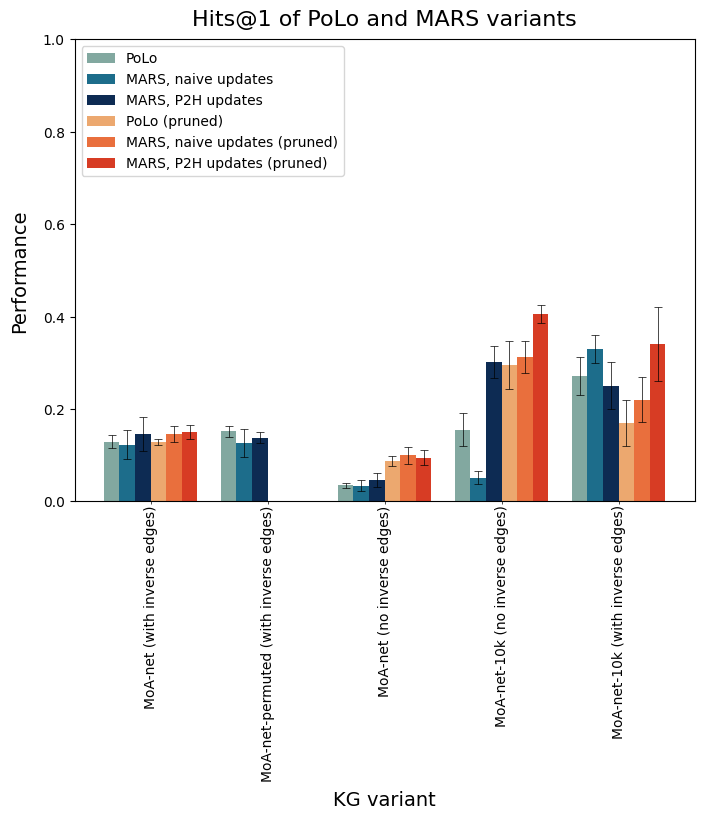

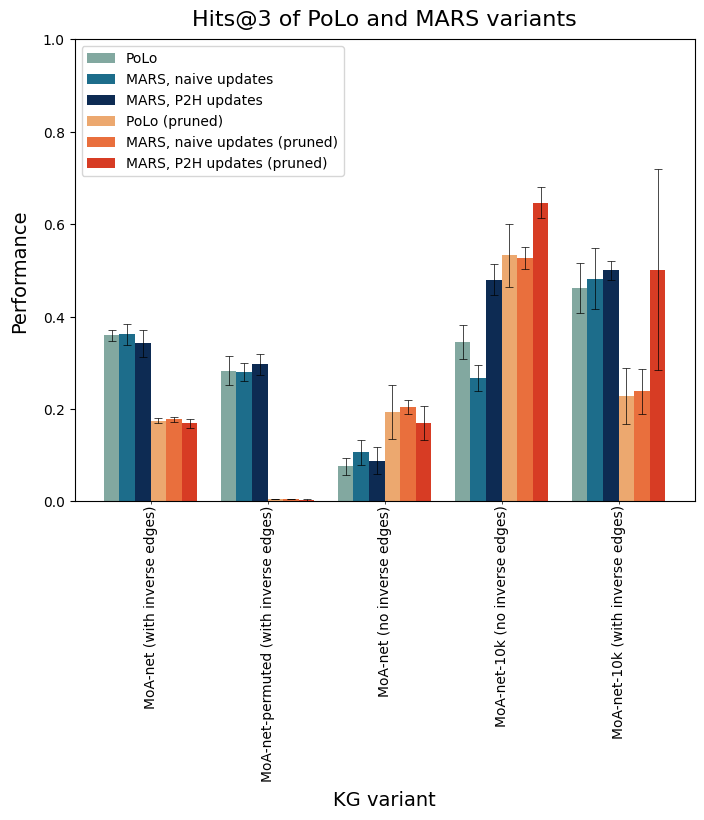

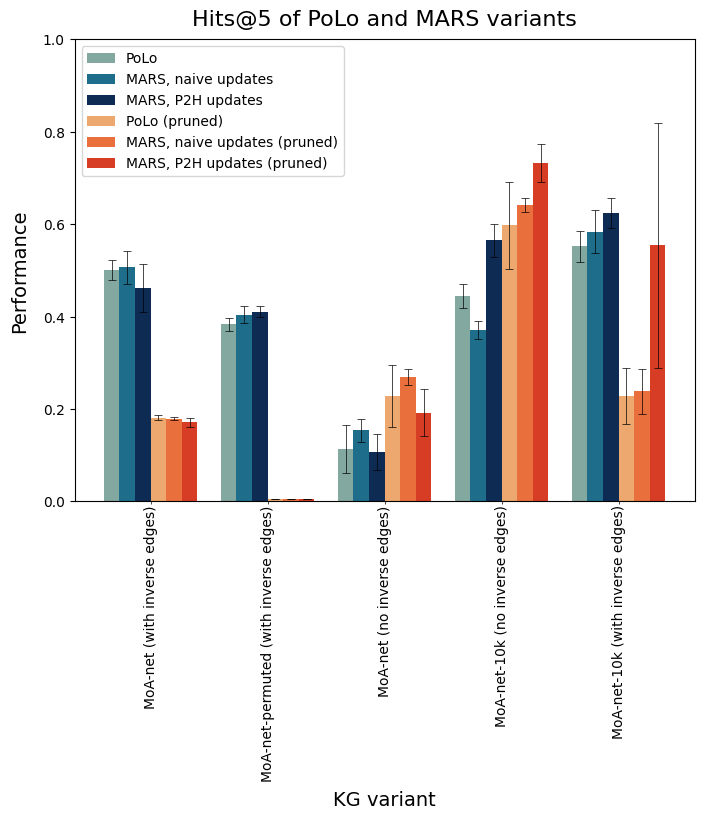

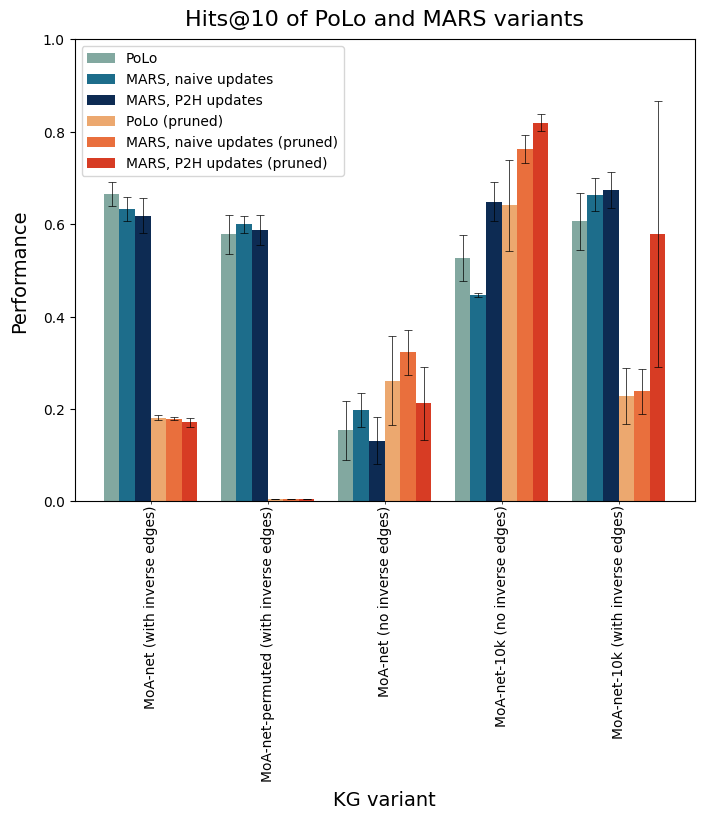

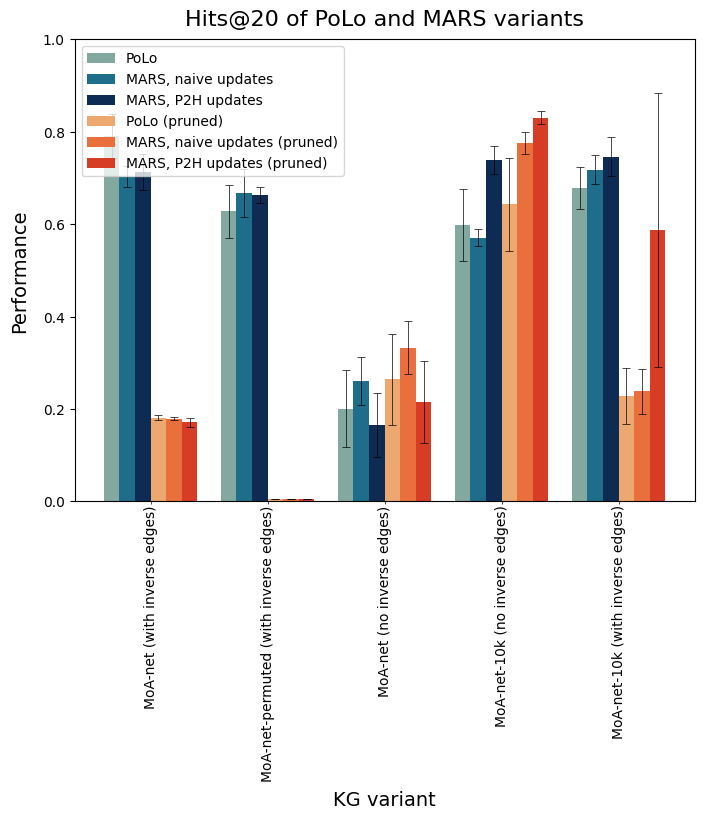

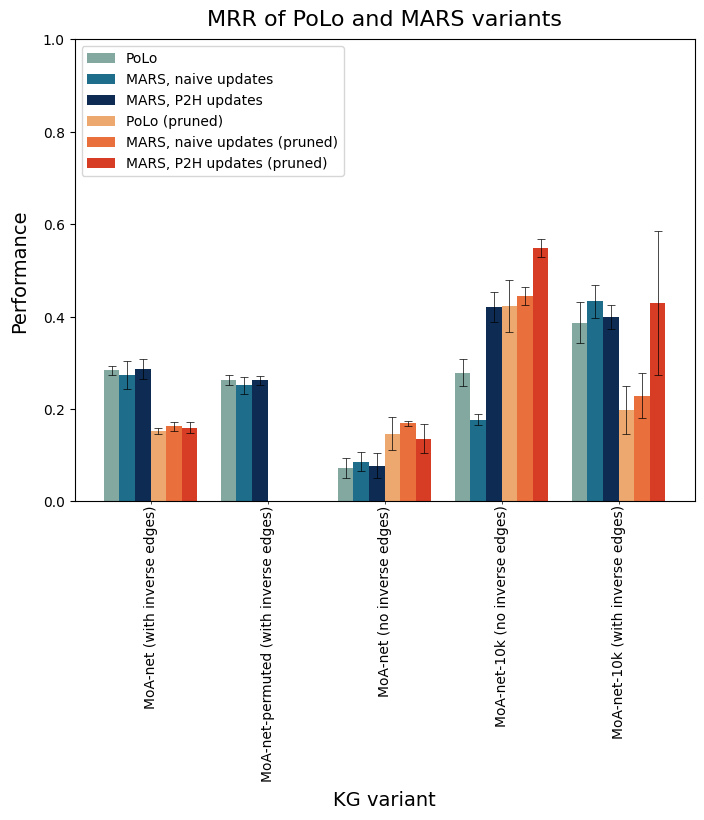

In [10]:
for metric_name, metric_table in metric_tables.items():
    table_values, table_sd = get_avg_std(metric_table)
    plot_metric(metric_name, table_values, table_sd)

In [11]:
# TODO I want a 2x2, 4-panel figure with ['Hits@1', 'Hits@3', 'Hits@10', 'MRR']

# also make those x-tick labels look better